# LangGraph and LangSmith - Agentic RAG Powered by LangChain

In the following notebook we'll complete the following tasks:

- 🤝 Breakout Room #1:
  1. Install required libraries
  2. Set Environment Variables
  3. Creating our Tool Belt
  4. Creating Our State
  5. Creating and Compiling A Graph!
  
- 🤝 Breakout Room #2:
  - Part 1: LangSmith Evaluator:
    1. Creating an Evaluation Dataset
    2. Adding Evaluators
  - Part 2:
    3. Adding Helpfulness Check and "Loop" Limits
    4. LangGraph for the "Patterns" of GenAI

# 🤝 Breakout Room #1

## Part 1: LangGraph - Building Cyclic Applications with LangChain

LangGraph is a tool that leverages LangChain Expression Language to build coordinated multi-actor and stateful applications that includes cyclic behaviour.

### Why Cycles?

In essence, we can think of a cycle in our graph as a more robust and customizable loop. It allows us to keep our application agent-forward while still giving the powerful functionality of traditional loops.

Due to the inclusion of cycles over loops, we can also compose rather complex flows through our graph in a much more readable and natural fashion. Effetively allowing us to recreate appliation flowcharts in code in an almost 1-to-1 fashion.

### Why LangGraph?

Beyond the agent-forward approach - we can easily compose and combine traditional "DAG" (directed acyclic graph) chains with powerful cyclic behaviour due to the tight integration with LCEL. This means it's a natural extension to LangChain's core offerings!

## Task 1:  Dependencies

We'll first install all our required libraries.

In [2]:
! pip install -qU langchain langchain_openai langchain-community langgraph arxiv duckduckgo_search==5.3.1b1

## Task 2: Environment Variables

We'll want to set both our OpenAI API key and our LangSmith environment variables.

In [56]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

In [4]:
from uuid import uuid4

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"AIE3 - LangGraph - {uuid4().hex[0:8]}"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key: ")

## Task 3: Creating our Tool Belt

As is usually the case, we'll want to equip our agent with a toolbelt to help answer questions and add external knowledge.

There's a tonne of tools in the [LangChain Community Repo](https://github.com/langchain-ai/langchain/tree/master/libs/community/langchain_community/tools) but we'll stick to a couple just so we can observe the cyclic nature of LangGraph in action!

We'll leverage:

- [Duck Duck Go Web Search](https://github.com/langchain-ai/langchain/tree/master/libs/community/langchain_community/tools/ddg_search)
- [Arxiv](https://github.com/langchain-ai/langchain/tree/master/libs/community/langchain_community/tools/arxiv)

####🏗️ Activity #1:

Please add the tools to use into our toolbelt.

> NOTE: Each tool in our toolbelt should be a method.

In [5]:
from langchain_community.tools.ddg_search import DuckDuckGoSearchRun
from langchain_community.tools.arxiv.tool import ArxivQueryRun

tool_belt = [
    DuckDuckGoSearchRun(),
    ArxivQueryRun()

]

### Actioning with Tools

Now that we've created our tool belt - we need to create a process that will let us leverage them when we need them.

We'll use the built-in [`ToolExecutor`](https://github.com/langchain-ai/langgraph/blob/fab950acfbf5fea46c9313dca34ee2ae01f1728b/libs/langgraph/langgraph/prebuilt/tool_executor.py#L50) to do so.

In [6]:
from langgraph.prebuilt import ToolExecutor

tool_executor = ToolExecutor(tool_belt)

### Model

Now we can set-up our model! We'll leverage the familiar OpenAI model suite for this example - but it's not *necessary* to use with LangGraph. LangGraph supports all models - though you might not find success with smaller models - as such, they recommend you stick with:

- OpenAI's GPT-3.5 and GPT-4
- Anthropic's Claude
- Google's Gemini

> NOTE: Because we're leveraging the OpenAI function calling API - we'll need to use OpenAI *for this specific example* (or any other service that exposes an OpenAI-style function calling API.

In [47]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4", temperature=0)

Now that we have our model set-up, let's "put on the tool belt", which is to say: We'll bind our LangChain formatted tools to the model in an OpenAI function calling format.

In [48]:
from langchain_core.utils.function_calling import convert_to_openai_function

functions = [convert_to_openai_function(t) for t in tool_belt]
model = model.bind_functions(functions)

#### ❓ Question #1:

How does the model determine which tool to use?

In Langraph, the model's decision on which tool to use typically involves a process called "tool selection" or "action selection." This process is usually handled by an agent, which is a higher-level abstraction that combines a language model with a decision-making framework. Here's how it generally works:

Prompt Engineering:
The system prompt given to the model includes descriptions of available tools and their functions. This informs the model about what tools are at its disposal.
Task Analysis:
The model analyzes the user's query or the current state of the task to determine what kind of action or information is needed.
Tool Matching:
Based on its understanding of the task and the available tools, the model tries to match the current need with the most appropriate tool.
Decision Making:
The model generates a response that includes its reasoning about which tool to use and why. 
Execution:
The system then executes the chosen tool with the provided input.
Observation:
The result of the tool's execution is fed back to the model as an observation.
Iteration:
The model then decides if the task is complete or if it needs to use another tool based on the new information.

In LangGraph specifically, this process can be implemented using a state machine where each state represents a different stage of the decision-making process. The transitions between states are determined by the model's outputs and the results of tool executions.


## Task 4: Putting the State in Stateful

Earlier we used this phrasing:

`coordinated multi-actor and stateful applications`

So what does that "stateful" mean?

To put it simply - we want to have some kind of object which we can pass around our application that holds information about what the current situation (state) is. Since our system will be constructed of many parts moving in a coordinated fashion - we want to be able to ensure we have some commonly understood idea of that state.

LangGraph leverages a `StatefulGraph` which uses an `AgentState` object to pass information between the various nodes of the graph.

There are more options than what we'll see below - but this `AgentState` object is one that is stored in a `TypedDict` with the key `messages` and the value is a `Sequence` of `BaseMessages` that will be appended to whenever the state changes.

Let's think about a simple example to help understand exactly what this means (we'll simplify a great deal to try and clearly communicate what state is doing):

1. We initialize our state object:
  - `{"messages" : []}`
2. Our user submits a query to our application.
  - New State: `HumanMessage(#1)`
  - `{"messages" : [HumanMessage(#1)}`
3. We pass our state object to an Agent node which is able to read the current state. It will use the last `HumanMessage` as input. It gets some kind of output which it will add to the state.
  - New State: `AgentMessage(#1, additional_kwargs {"function_call" : "WebSearchTool"})`
  - `{"messages" : [HumanMessage(#1), AgentMessage(#1, ...)]}`
4. We pass our state object to a "conditional node" (more on this later) which reads the last state to determine if we need to use a tool - which it can determine properly because of our provided object!

In [9]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
import operator
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
  messages: Annotated[list, add_messages]

## Task 5: It's Graphing Time!

Now that we have state, and we have tools, and we have an LLM - we can finally start making our graph!

Let's take a second to refresh ourselves about what a graph is in this context.

Graphs, also called networks in some circles, are a collection of connected objects.

The objects in question are typically called nodes, or vertices, and the connections are called edges.

Let's look at a simple graph.

![image](https://i.imgur.com/2NFLnIc.png)

Here, we're using the coloured circles to represent the nodes and the yellow lines to represent the edges. In this case, we're looking at a fully connected graph - where each node is connected by an edge to each other node.

If we were to think about nodes in the context of LangGraph - we would think of a function, or an LCEL runnable.

If we were to think about edges in the context of LangGraph - we might think of them as "paths to take" or "where to pass our state object next".

Let's create some nodes and expand on our diagram.

> NOTE: Due to the tight integration with LCEL - we can comfortably create our nodes in an async fashion!

In [49]:
from langgraph.prebuilt import ToolInvocation
import json
from langchain_core.messages import FunctionMessage

def call_model(state):
  messages = state["messages"]
  response = model.invoke(messages)
  return {"messages" : [response]}

def call_tool(state):
  last_message = state["messages"][-1]

  action = ToolInvocation(
      tool=last_message.additional_kwargs["function_call"]["name"],
      tool_input=json.loads(
          last_message.additional_kwargs["function_call"]["arguments"]
      )
  )

  response = tool_executor.invoke(action)

  function_message = FunctionMessage(content=str(response), name=action.tool)

  return {"messages" : [function_message]}

Now we have two total nodes. We have:

- `call_model` is a node that will...well...call the model
- `call_tool` is a node which will call a tool

Let's start adding nodes! We'll update our diagram along the way to keep track of what this looks like!


In [19]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)

workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)

Let's look at what we have so far:

![image](https://i.imgur.com/md7inqG.png)

In [20]:
from IPython.display import Image, display

try:
    display(Image(workflow.compile().get_graph().draw_mermaid_png()))#state_update_bot
except Exception:
    # This requires some extra dependencies and is optional
    pass

Next, we'll add our entrypoint. All our entrypoint does is indicate which node is called first.

In [26]:
workflow = StateGraph(AgentState)

workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)
#------------------------------------

workflow.set_entry_point("agent")

In [27]:
from IPython.display import Image, display

try:
    display(Image(workflow.get_graph().draw_mermaid_png()))#state_update_bot
except Exception:
    # This requires some extra dependencies and is optional
    pass

![image](https://i.imgur.com/wNixpJe.png)

Now we want to build a "conditional edge" which will use the output state of a node to determine which path to follow.

We can help conceptualize this by thinking of our conditional edge as a conditional in a flowchart!

Notice how our function simply checks if there is a "function_call" kwarg present.

Then we create an edge where the origin node is our agent node and our destination node is *either* the action node or the END (finish the graph).

It's important to highlight that the dictionary passed in as the third parameter (the mapping) should be created with the possible outputs of our conditional function in mind. In this case `should_continue` outputs either `"end"` or `"continue"` which are subsequently mapped to the action node or the END node.

In [28]:
def should_continue(state):
  last_message = state["messages"][-1]

  if "function_call" not in last_message.additional_kwargs:
    return "end"

  return "continue"

workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue" : "action",
        "end" : END
    }
)

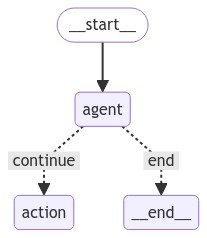

In [30]:
from IPython.display import Image, display

try:
    display(Image(workflow.compile().get_graph().draw_mermaid_png()))#state_update_bot
except Exception:
    # This requires some extra dependencies and is optional
    pass

Note: On my vscode, until the time I had not my edges added, it was not displayed!

Let's visualize what this looks like.

![image](https://i.imgur.com/8ZNwKI5.png)

Finally, we can add our last edge which will connect our action node to our agent node. This is because we *always* want our action node (which is used to call our tools) to return its output to our agent!

In [33]:
workflow.add_edge("action", "agent")
# from "action" node back to "agent" node that makes decion either continue or finishes the cycle.

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


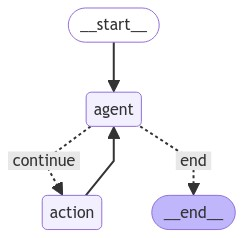

In [32]:
display(Image(workflow.compile().get_graph().draw_mermaid_png()))

Let's look at the final visualization.

![image](https://i.imgur.com/NWO7usO.png)

All that's left to do now is to compile our workflow - and we're off!

In [34]:
app = workflow.compile()

#### ❓ Question #2:

Is there any specific limit to how many times we can cycle? No. we have the potential situation of never exiting the loop.

If not, how could we impose a limit to the number of cycles?  We can add an artificial limit on how many "loops" the agent can go through - this will help us to avoid the potential situation where we never exit the loop. len(state["messages"])

#### Helper Function to print messages

In [37]:
def print_messages(messages):
  next_is_tool = False
  initial_query = True
  for message in messages["messages"]:
    if "function_call" in message.additional_kwargs:
      print()
      print(f'Tool Call - Name: {message.additional_kwargs["function_call"]["name"]} + Query: {message.additional_kwargs["function_call"]["arguments"]}')
      next_is_tool = True
      continue
    if next_is_tool:
      print(f"Tool Response: {message.content}")
      next_is_tool = False
      continue
    if initial_query:
      print(f"Initial Query: {message.content}")
      print()
      initial_query = False
      continue
    print()
    print(f"Agent Response: {message.content}")


## Using Our Graph

Now that we've created and compiled our graph - we can call it *just as we'd call any other* `Runnable`!

Let's try out a few examples to see how it fairs:

In [50]:
from langchain_core.messages import HumanMessage

inputs = {"messages" : [HumanMessage(content="What is RAG in the context of Large Language Models? When did it break onto the scene?")]}

messages = app.invoke(inputs)

print_messages(messages)

Initial Query: What is RAG in the context of Large Language Models? When did it break onto the scene?


Agent Response: RAG, or Retrieval-Augmented Generation, is a method used in large language models to enhance their ability to generate responses. It combines the benefits of retriever models, which are good at using a large corpus of documents to find relevant information, and seq2seq models, which are good at generating fluent text.

In the context of large language models, RAG allows the model to use a large corpus of documents to generate responses. It does this by first retrieving relevant documents from the corpus using a retriever model, and then using a seq2seq model to generate a response based on the retrieved documents.

RAG was introduced by Facebook AI in a paper titled "Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks" which was published in October 2020. The model demonstrated state-of-the-art performance on several knowledge-intensive tasks, showing the

Let's look at what happened:

1. Our state object was populated with our request
2. The state object was passed into our entry point (agent node) and the agent node added an `AIMessage` to the state object and passed it along the conditional edge
3. The conditional edge received the state object, found the "function_call" `additional_kwarg`, and sent the state object to the action node
4. The action node added the response from the OpenAI function calling endpoint to the state object and passed it along the edge to the agent node
5. The agent node added a response to the state object and passed it along the conditional edge
6. The conditional edge received the state object, could not find the "function_call" `additional_kwarg` and passed the state object to END where we see it output in the cell above!

Now let's look at an example that shows a multiple tool usage - all with the same flow!

In [39]:
inputs = {"messages" : [HumanMessage(content="What is QLoRA in Machine Learning? Are their any technical papers that could help me understand? Once you have that information, can you look up the bio of the first author on the QLoRA paper?")]}

messages = app.invoke(inputs)

print_messages(messages)

Initial Query: What is QLoRA in Machine Learning? Are their any technical papers that could help me understand? Once you have that information, can you look up the bio of the first author on the QLoRA paper?


Tool Call - Name: duckduckgo_search + Query: {"query":"QLoRA in Machine Learning"}
Tool Response: Let's jump on LoRA. Low-Rank Adaptation of LLMs (LoRA) So, in usual fine-tuning, we. Take a pretrained model. Do Transfer Learning over new training data to slightly adjust these pre-trained weights Large Language Models (LLMs) are currently a hot topic in the field of machine learning. Imagine you're an ML Engineer and your company has access to GPUs and open-source LLMs like LLAMA/Falcon ... Our results show that QLoRA finetuning on a small high-quality dataset leads to state-of-the-art results, even when using smaller models than the previous SoTA. We provide a detailed analysis of chatbot performance based on both human and GPT-4 evaluations showing that GPT-4 evaluations are a c

####🏗️ Activity #2:

--------------------------------------------------------------------------
Please write out the steps the agent took to arrive at the correct answer.

--------------------------------------------------------------------------

IT BREAKS THE COMPLEX QUERY, RETRIEVS RELAVANT INFORMATION USING THE APPROPRIATE TOOLS. THEN, GEBERATE RESPONSE BY HAVING THE KNOWLEDGE GATHERRED.

For the Initial Query: What is QLoRA in Machine Learning? Are their any technical papers that could help me understand? Once you have that information, can you look up the bio of the first author on the QLoRA paper?

1. What is QLoRA in Machine Learning? -> Tool Call - Name: duckduckgo_search + Query: {"query":"QLoRA in Machine Learning"}
2. Are their any technical papers that could help me understand? -> Tool Call - Name: arxiv + Query: {"query":"QLoRA in Machine Learning"}:
THREE research papers retrieved from arxiv.
3. Once you have that information, can you look up the bio of the first author on the QLoRA paper? -> Tool Call - Name: duckduckgo_search + Query: {"query":"Tim Dettmers bio"}

4. Agent Response: QLoRA stands for "Quantized Low-Rank Adapters" and is an efficient finetuning approach that reduces memory usage while preserving full 16-bit finetuning task performance for large language models (LLMs). QLoRA backpropagates gradients through a frozen, 4-bit quantized pretrained language model into Low Rank Adapters (LoRA). The best model family resulting from QLoRA, named Guanaco, outperforms all previous openly released models on the Vicuna benchmark.

The technical paper "QLoRA: Efficient Finetuning of Quantized LLMs" was authored by Tim Dettmers, Artidoro Pagnoni, Ari Holtzman, and Luke Zettlemoyer. Tim Dettmers is a researcher who focuses on making foundation models, such as ChatGPT, accessible to researchers and practitioners by reducing their resource requirements. He works on developing novel compression and networking algorithms and building systems that allow for memory-efficient, fast, and cost-effective deep learning.

If you would like more information or details on the QLoRA paper or Tim Dettmers, please let me know!

# 🤝 Breakout Room #2

## Part 1: LangSmith Evaluator

### Pre-processing for LangSmith

To do a little bit more preprocessing, let's wrap our LangGraph agent in a simple chain.

In [51]:
def convert_inputs(input_object):
  return {"messages" : [HumanMessage(content=input_object["question"])]}

def parse_output(input_state):
  return input_state["messages"][-1].content

agent_chain = convert_inputs | app | parse_output

In [41]:
agent_chain.invoke({"question" : "What is RAG?"})

'RAG, or retrieval-augmented generation, combines retrieval and generation models to enhance text quality and relevance. It is a technique that enhances generative AI models with facts from external sources. RAG works by grounding the model on external sources of knowledge to improve the quality of generated responses. It is used in various NLP tasks to provide more accurate and relevant information.'

### Task 1: Creating An Evaluation Dataset

Just as we saw last week, we'll want to create a dataset to test our Agent's ability to answer questions.

In order to do this - we'll want to provide some questions and some answers. Let's look at how we can create such a dataset below.

```python
questions = [
    "What optimizer is used in QLoRA?",
    "What data type was created in the QLoRA paper?",
    "What is a Retrieval Augmented Generation system?",
    "Who authored the QLoRA paper?",
    "What is the most popular deep learning framework?",
    "What significant improvements does the LoRA system make?"
]

answers = [
    {"must_mention" : ["paged", "optimizer"]},
    {"must_mention" : ["NF4", "NormalFloat"]},
    {"must_mention" : ["ground", "context"]},
    {"must_mention" : ["Tim", "Dettmers"]},
    {"must_mention" : ["PyTorch", "TensorFlow"]},
    {"must_mention" : ["reduce", "parameters"]},
]
```

####🏗️ Activity #3:

Please create a dataset in the above format with at least 5 questions.

In [42]:
questions = [
    "What is the key innovation in the PEFT (Parameter-Efficient Fine-Tuning) approach?",
    "How does the Mixtral 8x7B model differ from traditional large language models?",
    "What is the main advantage of using Retrieval-Augmented Generation in language models?",
    "What is the primary purpose of the RLHF (Reinforcement Learning from Human Feedback) technique?",
    "How does the GPT (Generative Pre-trained Transformer) architecture revolutionize natural language processing?"
]

answers = [
    {"must_mention": ["adapter layers", "efficiency"]},
    {"must_mention": ["mixture of experts", "sparse activation"]},
    {"must_mention": ["up-to-date information", "reduced hallucinations"]},
    {"must_mention": ["align model", "human preferences"]},
    {"must_mention": ["self-attention mechanism", "transfer learning"]}

]

Now we can add our dataset to our LangSmith project using the following code which we saw last Thursday!

In [59]:
from langsmith import Client

client = Client()
dataset_name = f"Retrieval Augmented Generation - Evaluation Dataset - {uuid4().hex[0:8]}"

dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="Questions about the Advanced developments and techniques in artificial intelligence, Paper to Evaluate RAG over the same paper."
)

client.create_examples(
    inputs=[{"question" : q} for q in questions],
    outputs=answers,
    dataset_id=dataset.id,
)

#### ❓ Question #3:

How are the correct answers associated with the questions? It sounds like it focuses on key words rather than more semantic approach.

> NOTE: Feel free to indicate if this is problematic or : Yes! it is problematic.

1. Limitations of keyword-based matching: (
Lacks understanding of context and nuance
May miss semantically correct answers that use different terminology
Can lead to false positives if keywords appear without proper context)


2. Oversimplification of complex topics: (
Reducing answers to a few keywords doesn't capture the depth of understanding required
Fails to account for the explanatory nature of many questions in this field)


3. Potential for gaming the system: (
Encourages memorization of keywords rather than true comprehension
May lead to shallow learning focused on buzzwords)


4. Lack of flexibility: (
Doesn't allow for alternative explanations or approaches
May not recognize valid answers that use synonyms or related concepts
)

5. Misalignment with the nature of the field: (
Advanced NLP and ML often require nuanced understanding that goes beyond simple keyword matching
The field evolves rapidly, and fixed keywords may quickly become outdated)


### Task 2: Adding Evaluators

Now we can add a custom evaluator to see if our responses contain the expected information.

We'll be using a fairly naive exact-match process to determine if our response contains specific strings.

In [60]:
from langsmith.evaluation import EvaluationResult, run_evaluator

@run_evaluator
def must_mention(run, example) -> EvaluationResult:
    prediction = run.outputs.get("output") or ""
    required = example.outputs.get("must_mention") or []
    score = all(phrase in prediction for phrase in required)
    return EvaluationResult(key="must_mention", score=score)

#### ❓ Question #4:

What are some ways you could improve this metric as-is?
A more robust approach would involve:

1. Semantic understanding of questions and answers
2. Consideration of context and relationships between concepts
3. Allowance for multiple valid ways of expressing the same idea
4. Evaluation of the overall coherence and accuracy of the answer, not just presence of keywords

> NOTE: Alternatively you can suggest where gaps exist in this method.

Now that we have created our custom evaluator - let's initialize our `RunEvalConfig` with it, and a few others:

- `"criteria"` includes the default criteria which, in this case, means "helpfulness"
- `"cot_qa"` includes a criteria that bases whether or not the answer is correct by utilizing a Chain of Thought prompt and the provided context to determine if the response is correct or not.

In [61]:
from langchain.smith import RunEvalConfig, run_on_dataset

eval_config = RunEvalConfig(
    custom_evaluators=[must_mention],
    evaluators=[
        "criteria", #helpfulness
        "cot_qa",
    ],
)

Task 3: Evaluating

All that is left to do is evaluate our agent's response!

In [62]:
client.run_on_dataset(
    dataset_name=dataset_name, # with 5 created questions
    llm_or_chain_factory=agent_chain, # convert_inputs | app | parse_output
    evaluation=eval_config,
    verbose=True,
    project_name=f"RAG Pipeline - Evaluation - {uuid4().hex[0:8]}",
    project_metadata={"version": "1.0.0"},
)

View the evaluation results for project 'RAG Pipeline - Evaluation - 2b6478e2' at:
https://smith.langchain.com/o/011bb40b-887f-5e52-ae2b-cac14745aa21/datasets/558de6f2-5e92-4afe-87e5-eb5070e57d80/compare?selectedSessions=68735500-6101-4666-8ad7-8880e73a3573

View all tests for Dataset Retrieval Augmented Generation - Evaluation Dataset - a775505b at:
https://smith.langchain.com/o/011bb40b-887f-5e52-ae2b-cac14745aa21/datasets/558de6f2-5e92-4afe-87e5-eb5070e57d80


ValueError: Evaluation with the <class 'langchain.evaluation.criteria.eval_chain.CriteriaEvalChain'> requires a language model to function. Failed to create the default 'gpt-4' model. Please manually provide an evaluation LLM or check your openai credentials.

## Part 2: LangGraph with Helpfulness:

### Task 3: Adding Helpfulness Check and "Loop" Limits

Now that we've done evaluation - let's see if we can add an extra step where we review the content we've generated to confirm if it fully answers the user's query!

We're going to make a few key adjustments to account for this:

1. We're going to add an artificial limit on how many "loops" the agent can go through - this will help us to avoid the potential situation where we never exit the loop.
2. We'll add a custom node and conditional edge to determine if the response was helpful enough.

First, let's define our state again - we can check the length of the state object, so we don't need additional state for this.

In [63]:
class AgentState(TypedDict):
  messages: Annotated[list, add_messages]

We're going to add a custom helpfulness check here!

In [64]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

def check_helpfulness(state):
  initial_query = state["messages"][0]
  final_response = state["messages"][-1]

  if len(state["messages"]) > 10:
    return "END"

  prompt_template = """\
  Given an initial query and a final response, determine if the final response is extremely helpful or not. Please indicate helpfulness with a 'Y' and unhelpfulness as an 'N'.

  Initial Query:
  {initial_query}

  Final Response:
  {final_response}"""

  prompt_template = PromptTemplate.from_template(prompt_template)

  helpfulness_check_model = ChatOpenAI(model="gpt-4")

  helpfulness_chain = prompt_template | helpfulness_check_model | StrOutputParser()

  helpfulness_response = helpfulness_chain.invoke({"initial_query" : initial_query.content, "final_response" : final_response.content})

  if "Y" in helpfulness_response:
    print("Helpful!")
    return "end"
  else:
    print("Not helpful!")
    return "continue"

def dummy_node(state):
  return

####🏗️ Activity #4:

Please write what is happening in our `check_helpfulness` function!
we used the `built-in-evaluator` helfulness before. Now, we define function:
1. first message in state is the input query by user, last massage in state is the answer generate by agent.
2. The helfulness check model (gpt4) is in a role to examine and decides if the generated reponse is extremely helpful or not.
3. If `Yes`,it returns end and later agent ends, otherwise, it returns `continues`, and later agent takes action to call tools.

Now we can set our graph up! This process will be almost entirely the same - with the inclusion of one additional node/conditional edge!

####🏗️ Activity #5:

Please write markdown for the following cells to explain what each is doing.

##### YOUR MARKDOWN HERE

In [74]:
graph_with_helpfulness_check = StateGraph(AgentState)

graph_with_helpfulness_check.add_node("agent", call_model)
# node agent has access to call model.
graph_with_helpfulness_check.add_node("action", call_tool)
# node action has access to call tools at its disposal.
graph_with_helpfulness_check.add_node("passthrough", dummy_node)
# node passthrough 

##### YOUR MARKDOWN HERE
 SETTING THE GRAPH WORKFLOW: 
1. AN INSTANCE OF THE STATEGRAPH CREATED OF THE TYPE AgentState. THREE NODES ADDED TO THE GRAPH USING add_node() method:
2. THE "agent" NODE IS ASSOCIATED WITH THE call_model FUNCTION.
3. THE "action" NODE IS ASSOCIATED WITH THE call_tool FUNCTION.
4. THE "passthrough" NODE IS A CUSTOM NODE THAT IS ASSOCIATED WITH CHECKING HELPFULNESS.

In [75]:
graph_with_helpfulness_check.set_entry_point("agent")

5. "agent" NODE IS SET AS THE ENTRY POINT.

In [76]:
graph_with_helpfulness_check.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue" : "action",
        "end" : "passthrough"
    }
)

graph_with_helpfulness_check.add_conditional_edges(
    "passthrough",
    check_helpfulness,
    {
        "continue" : "agent",
        "end" : END
    }
)

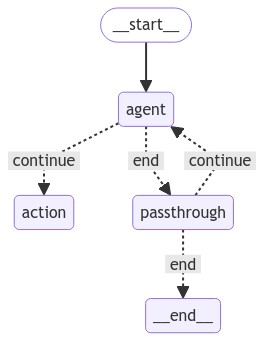

In [73]:
display(Image(graph_with_helpfulness_check.compile().get_graph().draw_mermaid_png()))

##### YOUR MARKDOWN HERE
6. FROM "agent" NODE, CONDITIONAL EDGE TO EITHER "action" NODE (IF "function_call" IN LAST MESSAGE IN STATE) OR "passthrough" NODE (IF END IS CALLED).
7. FROM "passthrough" NODE, THE CRITERIA IS CHECKED. IF MET A CONDITIONAL EDGE TO "end" NODE, OTHERWISE, CONTINUE BACK TO "agent" NODE FOR FURTHER TAKIND ACTION.

In [77]:
graph_with_helpfulness_check.add_edge("action", "agent")

8. FROM "action" NODE BACK TO "agent" NODE.

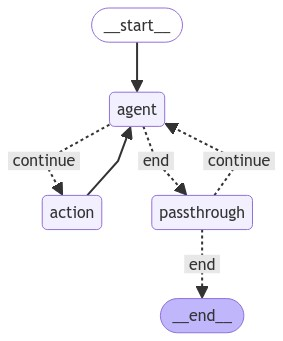

In [78]:
display(Image(graph_with_helpfulness_check.compile().get_graph().draw_mermaid_png()))

In [79]:
agent_with_helpfulness_check = graph_with_helpfulness_check.compile()

##### YOUR MARKDOWN HERE

In [81]:
inputs = {"messages" : [HumanMessage(content="Related to machine learning, what is LoRA? Also, who is Tim Dettmers? Also, what is Attention?")]}

messages = agent_with_helpfulness_check.invoke(inputs)

print_messages(messages)

Not helpful!
Not helpful!


KeyError: 'END'

### Task 4: LangGraph for the "Patterns" of GenAI

Let's ask our system about the 4 patterns of Generative AI:

1. Prompt Engineering
2. RAG
3. Fine-tuning
4. Agents

In [82]:
patterns = ["prompt engineering", "RAG", "fine-tuning", "LLM-based agents"]

In [83]:
for pattern in patterns:
  what_is_string = f"What is {pattern} and when did it break onto the scene??"
  inputs = {"messages" : [HumanMessage(content=what_is_string)]}
  messages = agent_with_helpfulness_check.invoke(inputs)
  print_messages(messages)
  print("\n\n")

Helpful!
Initial Query: What is prompt engineering and when did it break onto the scene??


Tool Call - Name: duckduckgo_search + Query: {
  "query": "Prompt engineering history"
}
Tool Response: This paper presents a comprehensive exploration of the evolution of prompt engineering and generation in the field of natural language processing (NLP). Starting from the early language models and information retrieval systems, we trace the key developments that have shaped prompt engineering over the years. The introduction of attention mechanisms in 2015 revolutionized language understanding ... Prompt Engineering didn't emerge overnight; its roots can be traced back to the early days of natural language processing and machine learning. Prompt engineering has moved far beyond simple instructions. Practitioners are meticulously crafting prompts to elicit specific responses and ensure that LLMs align with human goals and values. Looking ahead, it's clear we need to think critically about align